In [1003]:
!pip install tqdm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

import warnings

warnings.filterwarnings('ignore')

## Data Import \& Preprocessing

We first import and pre-process the data into a usable format.

The data are stored in two components. We process the component with the sequential chord data first below. 

### Chords Data Preprocessing

To do this, we define a dictionary and store the piece title as the key and the list of timestamps and chords as the item. The data are stored across 10 files, so we ingest the data from each file and concatenate them into one list.

In [3]:
music_types = ["orchestra", "piano"]
music_eras = ["baroque", "classical", "romantic", "modern"]

chords_data = {}

for music_type in music_types :
    for music_era in music_eras :
        filename = f"./project_data/chords-chordino_{music_type}_{music_era}.csv"

        piece_name = None
        piece_chords = None

        with open(filename, 'r') as f:
            for line in f:
                triple = line.split(",")

                if triple[0] != "" :
                    chords_data[piece_name] = piece_chords
                    
                    piece_name = triple[0].split("/")[1][:-1]
                    piece_chords = []
                else :
                    chord = triple[2][1:-2]
                    if chord != "N" :   
                        piece_chords.append((triple[1], chord))


We display the length of the `chords_data` list and output the first ten chords of the first song to ensure that it looks correct.

In [6]:
len(chords_data), chords_data["CrossEra-0001_Albinoni__sinata_a_cinque_no._6_in_g_minor_op._2_1_adagio.mp3"][0:10]

(1593,
 [('0.400000000', 'G_min'),
  ('2.300000000', 'D_min'),
  ('2.800000000', 'Eb_maj'),
  ('4.500000000', 'Bb_maj'),
  ('5.100000000', 'A_dim'),
  ('7.300000000', 'D_maj'),
  ('9.000000000', 'A_min_min7'),
  ('9.500000000', 'G_maj'),
  ('11.700000000', 'C_min'),
  ('12.300000000', 'D_maj_min7')])

### Pieces Data Preprocessing

We now process the second component of the data, where the rows are the piece titles and the pieces' attributes. This is simpler, and we simply split the line by comma to process the file as a `csv`.

In [9]:
pieces_data = {}

filename = "./project_data/cross-era_annotations.csv"

with open(filename, 'r') as f :
    col_names = f.readline()[:-2]
    col_names = col_names[:1] + col_names[2:]
    for line in f :
        data_row = line.split(",")[:-1]

        title = data_row[1]
        data_row = data_row[:1] + data_row[2:]
        
        pieces_data[title] = data_row

We print out the length of the data and the first row to ensure that the data ingestion looks correct.

In [12]:
len(pieces_data), pieces_data['CrossEra-0001_Albinoni__sinata_a_cinque_no._6_in_g_minor_op._2_1_adagio.mp3']

(2000,
 ['orchestra_baroque',
  'CrossEra-0001',
  'orchestra',
  'G',
  'minor',
  'Albinoni; Tomaso',
  '1671-1751',
  'Italy'])

We see that there are 2000 rows, whereas there are only 1593 rows in the previous component of the data, so we need to check which piece titles are included in both datasets.

In [15]:
keep_pieces = []
toss_pieces = []

for title in pieces_data :
    try :
        chords_data[title]
        keep_pieces.append(title)

    except :
        toss_pieces.append(title)

We check which datapoints (piece titles) were kept.

In [18]:
keep_pieces[0:10]

['CrossEra-0001_Albinoni__sinata_a_cinque_no._6_in_g_minor_op._2_1_adagio.mp3',
 'CrossEra-0002_Albinoni__sinata_a_cinque_no._6_in_g_minor_op._2_2_allegro.mp3',
 'CrossEra-0003_Albinoni__sinata_a_cinque_no._6_in_g_minor_op._2_3_grave.mp3',
 'CrossEra-0004_Albinoni__sinata_a_cinque_no._6_in_g_minor_op._2_4_allegro.mp3',
 'CrossEra-0005_Albinoni_concerto_in_a_minor_bwv_1044_adagio_ma_non_tanto_e_dolce.mp3',
 'CrossEra-0006_Albinoni_concerto_in_a_minor_bwv_1044_alla_breve.mp3',
 'CrossEra-0007_Albinoni_concerto_in_a_minor_bwv_1044_allegro.mp3',
 'CrossEra-0008_Albinoni_concerto_in_b_flat_major_op.9_no.11_adagio.mp3',
 'CrossEra-0009_Albinoni_concerto_in_b_flat_major_op.9_no.11_allegro.mp3',
 'CrossEra-0010_Albinoni_concerto_in_c_major_op.9_no.5_adagio_non_troppo.mp3']

Thus concludes our data pre-processing. Now, we begin the data processing component, wherein we experiment with how to transform the sequential data for each piece into some sort of `standardized` format such that it can be used in the clustering.

## Data Processing for Sequential Chord Data

### Components of Chord Processing

We want to separate out this data into a few sort of "orthogonal" components.

1. First is the chord frequency: after the shift to tonic, we want to see the frequencies of the intervals used.
2. Second is the "transition" matrix for the chords: we want to see the chord progressions for each piece, as different eras of music use different types of chord progressions at different frequencies (we will experiment with different levels of depth for the chain).
3. Third is the length: simply how many chords there are.
4. Fourth is the mode of the piece: we want to want to separate out major and minor pieces, as these often have different conventions and structures.
5. Fourth is the start chord and the end chord, as well as the start and end mode: some pieces will end on a specific chord (hehehe picardy third).

### Rotational Mapping around the Circle of Fifths

We first need to shift the frequencies of the chords to tonic. This means that, despite the tonic key and the mode (major or minor) of the piece, we have the "standardized" chord frequencies.

We define three functions to achieve this goal. The first processes the chords to extract the key the chord is in, the second maps the chords to tonic, and the third computes the frequencies.

In [24]:
def chord_name_processing(chords) :
    return [chord.split("_")[0] for chord in chords]

def chord_processing(chords, tonic) :
    fifths_mapping = {"C":1, "G":2, "D":3, "A":4, "E":5, "B":6, "F#":7, "Gb":7, "C#":8, "Db":8, "G#":9, "Ab":9, "D#":10, "Eb":10, "A#":11, "Bb":11, "F":12}
    chords = chord_name_processing(chords)
    
    try :
        
        offset = fifths_mapping[tonic]
    
        chords = [(fifths_mapping[chord] - offset + 1) if (fifths_mapping[chord] - offset + 1) > 0 else (fifths_mapping[chord] - offset + 13) for chord in chords]
    
        intervals_mapping = {1 : "I", 2 : "V", 3 : "II", 4 : "VI", 5 : "III", 6 : "VII", 7 : "T", 8 : "II", 9 : "VI", 10 : "III", 11 : "VII", 12: "IV"}
        mapped_chords = [intervals_mapping[chord] for chord in chords]
        
        return mapped_chords
        
    except KeyError :
        
        tonic = max(set(chords), key = chords.count)

        offset = fifths_mapping[tonic]
    
        chords = [(fifths_mapping[chord] - offset + 1) if (fifths_mapping[chord] - offset + 1) > 0 else (fifths_mapping[chord] - offset + 13) for chord in chords]
    
        intervals_mapping = {1 : "I", 2 : "V", 3 : "II", 4 : "VI", 5 : "III", 6 : "VII", 7 : "T", 8 : "II", 9 : "VI", 10 : "III", 11 : "VII", 12: "IV"}
        mapped_chords = [intervals_mapping[chord] for chord in chords]

        if tonic == chords[0] or tonic == chords[-1] or chords[0] == chords[-1]:
            mapped_chords.append(tonic)
            mapped_chords.append(-1)
        
        return mapped_chords
        
def chord_frequencies(chords) :
    intervals_ordering = {"I":1, "II":2, "III":3, "IV": 4, "T":5, "V":6, "VI":7, "VII":8}

    chord_frequencies = [0] * 8

    try :
        for chord in chords :
            chord_frequencies[intervals_ordering[chord] - 1] += 1
    except KeyError :
        return [None] * 8
        
    return chord_frequencies


We now test the above code to ensure that it is working properly.

In [27]:
test_chords = [chords[1] for chords in chords_data[keep_pieces[0]]]
mapped_chords = chord_processing(test_chords, pieces_data[keep_pieces[0]][3])

Print the mapped-to-tonic chords, written in Roman numerals (a tritone is marked as `T`).

In [30]:
mapped_chords[0:10]

['I', 'V', 'VI', 'III', 'II', 'V', 'II', 'I', 'IV', 'V']

In [32]:
chord_freqs = chord_frequencies(mapped_chords)
chord_freqs = [freq/sum(chord_freqs) for freq in chord_freqs]

We print the chord frequencies.

In [35]:
chord_freqs

[0.18604651162790697,
 0.11627906976744186,
 0.16279069767441862,
 0.13953488372093023,
 0.0,
 0.23255813953488372,
 0.09302325581395349,
 0.06976744186046512]

### Data Processing for the Classification Problem

We now need to process the data into usable tabular format.

In [38]:
music_list = []
composer_list = []

for piece in keep_pieces :
    
    piece_features = pieces_data[piece]

    composer_list.append(piece_features[5:])
    
    era = piece_features[0].split("_")[1]
    instrumentation = piece_features[2]
    key = piece_features[3]
    mode = int(piece_features[4] == "major")

    chords = [chord[1] for chord in chords_data[piece]]
    chord_sequence = chord_processing(chord_name_processing(chords), key)

    if chord_sequence[-1] == -1 :
        key = chord_sequence[-2]
        chord_sequence = chord_sequence[:-2]

    first_chord = chord_sequence[0]
    last_chord = chord_sequence[-1]

    length = float(chords_data[piece][-1][0])
    chord_freqs = chord_frequencies(chord_sequence)

    piece_features = [era, instrumentation, key, mode]

    music_list.append([piece[14:-4]] + piece_features + chord_freqs + [first_chord] + [last_chord] + [length])

In [40]:
column_names = ["title", "era", "instrumentation", "key", "mode", "I", "II", "III", "IV", "T", "V", "VI", "VII", "first_chord", "last_chord", "length"]

music_data = pd.DataFrame(music_list, columns = column_names)

In [42]:
music_data.sample(5)

,title,era,instrumentation,key,mode,I,II,III,IV,T,V,VI,VII,first_chord,last_chord,length
674,Liszt_the_struggle_for_existence_der_kampf_ums...,romantic,orchestra,various,0,5,7,3,1,3,5,5,5,T,I,132.5
1153,Mozart_sonata_b_major__andante_amoroso,classical,piano,Eb,1,53,24,8,20,1,38,16,6,I,I,387.2
947,Platti_piano_sonata_no._6_in_e_major_op._1__ii...,baroque,piano,E,1,23,15,16,1,3,26,11,11,I,I,268.9
1404,Brahms_Glenn_Gould_op10_ballade_no2_d-major,romantic,piano,D,1,17,24,36,18,3,14,36,14,I,I,480.2
1274,Milhaud_jeu,modern,piano,,0,4,0,1,3,1,3,2,1,V,VII,85.3


## Classification Problem, Attempt 0

In [195]:
feature_list0 = ['era', 'instrumentation', 'key', 'mode', "length"]

model_data0 = music_data[feature_list0]

In [197]:
class_map = {"baroque" : 1, "classical" : 2, "romantic" : 3, "modern" : 4}

model_data0["era"] = model_data0["era"].map(lambda x : class_map[x])

In [199]:
model_data0

,era,instrumentation,key,mode,length
0,1,orchestra,G,0,67.5
1,1,orchestra,G,0,132.5
2,1,orchestra,G,0,62.5
3,1,orchestra,G,0,103.8
4,1,orchestra,A,0,307.4
...,...,...,...,...,...
1587,3,piano,C#,0,210.9
1588,3,piano,Bb,1,193.2
1589,3,piano,F,1,711.6
1590,3,piano,Ab,0,174.4


### Classification with HistGradientBoost

We use the `HistGradientBoostingClassifier` for our classification problem. This is a good choice for multiple reasons: first, the quantity of features (before even including the sequential data) introduces collinearity. Second, the implementation of `HistGradientBoostingClassifier` in `sklearn` handles missing data automatically.

In [202]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier

In [204]:
X = model_data0[list(model_data0.columns)[1:]]
y = model_data0['era']

In [ ]:
learning_rates = [0.001, 0.01, 0.25, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
max_leafs = [10, 25, 50, 75, 100, 150, 200]

iterations = 10

scores = {}

for rate in range(len(learning_rates)) :
    for max_leaf in range(len(max_leafs)) :
        avg_score = 0
        
        for _ in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
            
            hgb = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'first_chord', 'last_chord'],
                                                 learning_rate = learning_rates[rate], 
                                                 max_leaf_nodes = max_leafs[max_leaf],
                                                 tol = 1e-5)

            hgb.fit(X_train, y_train)
            avg_score += hgb.score(X_test, y_test)

        scores[(rate, max_leaf)] = avg_score / iterations

In [ ]:
pairing = max(scores, key = scores.get)
print(pairing, scores[pairing])

In [216]:
rate_opt = learning_rates[pairing[0]]
leaves_opt = max_leafs[pairing[1]]

train_score = 0
test_score = 0

iterations = 50

for _ in range(iterations) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    
    hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key'],
                                                    learning_rate = rate_opt, 
                                                    max_leaf_nodes = leaves_opt,
                                                    tol = 1e-5,)
    
    hgb_classifier.fit(X_train, y_train)
    train_score += hgb_classifier.score(X_train, y_train)
    test_score += hgb_classifier.score(X_test, y_test)
    

print((train_score / iterations, test_score / iterations))

(0.8048241206030152, 0.5586934673366833)


## Classification Problem, Attempt 1

We first try doing the classification problem, without the sequential element of the chords data, treating each `era` as a class. We use the histograms created above, the first and last chord, and the length of the piece, all extracted from the chords data.

In [45]:
feature_list = ['era', 'instrumentation', 'key', 'mode', "I", "II", "III", "IV", "T", "V", "VI", "VII", "first_chord", "last_chord", "length"]

model_data = music_data[feature_list]

In [47]:
class_map = {"baroque" : 1, "classical" : 2, "romantic" : 3, "modern" : 4}

model_data["era"] = model_data["era"].map(lambda x : class_map[x])

In [49]:
model_data

,era,instrumentation,key,mode,I,II,III,IV,T,V,VI,VII,first_chord,last_chord,length
0,1,orchestra,G,0,8,5,7,6,0,10,4,3,I,I,67.5
1,1,orchestra,G,0,19,2,11,14,0,11,3,13,I,I,132.5
2,1,orchestra,G,0,8,2,4,9,0,6,3,8,III,I,62.5
3,1,orchestra,G,0,15,1,8,10,0,14,8,8,I,I,103.8
4,1,orchestra,A,0,22,18,21,27,2,11,10,24,III,V,307.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,3,piano,C#,0,31,11,13,13,0,17,14,12,I,I,210.9
1588,3,piano,Bb,1,14,13,4,1,3,10,17,10,V,I,193.2
1589,3,piano,F,1,58,33,41,40,11,52,52,24,I,I,711.6
1590,3,piano,Ab,0,24,6,10,2,1,5,3,1,I,I,174.4


### Classification with HistGradientBoost

We use the `HistGradientBoostingClassifier` for our classification problem. This is a good choice for multiple reasons: first, the quantity of features (before even including the sequential data) introduces collinearity. Second, the implementation of `HistGradientBoostingClassifier` in `sklearn` handles missing data automatically.

In [218]:
X = model_data[list(model_data.columns)[1:]]
y = model_data['era']

In [ ]:
learning_rates = [0.001, 0.01, 0.25, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
max_leafs = [10, 25, 50, 75, 100, 150, 200]

iterations = 10

scores = {}

for rate in range(len(learning_rates)) :
    for max_leaf in range(len(max_leafs)) :
        avg_score = 0
        
        for _ in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
            
            hgb = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'first_chord', 'last_chord'],
                                                 learning_rate = learning_rates[rate], 
                                                 max_leaf_nodes = max_leafs[max_leaf],
                                                 tol = 1e-5)

            hgb.fit(X_train, y_train)
            avg_score += hgb.score(X_test, y_test)

        scores[(rate, max_leaf)] = avg_score / iterations

In [ ]:
pairing = max(scores, key = scores.get)
print(pairing, scores[pairing])

In [64]:
rate_opt = learning_rates[pairing[0]]
leaves_opt = max_leafs[pairing[1]]

score = 0

iterations = 1000

for _ in range(iterations) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'first_chord', 'last_chord'],
                                                    learning_rate = rate_opt, 
                                                    max_leaf_nodes = leaves_opt,
                                                    tol = 1e-5,)
    
    hgb_classifier.fit(X_train, y_train)
    score += hgb_classifier.score(X_test, y_test)

print(score / iterations)

0.6779341692789973


## Sequential Feature Extraction, Attempt 1

We first define the function used to create the transition matrix, with only one layer of depth.

In [66]:
labels = {"I":1, "II":2, "III":3, "IV": 4, "T":5, "V":6, "VI":7, "VII":8}
transition_labels = []

for i in labels :
    for j in labels :
        transition_labels.append(i + '-' + j)

def get_transition_matrix(chords) :
    if len(chords) < 2:
        return np.zeros(64)

    transitions = np.zeros((8, 8))

    for i in range(len(chords) - 1) :
        transitions[labels[chords[i]] - 1][labels[chords[i + 1]] - 1] += 1
        
    transitions = transitions / np.sum(transitions, axis = 1).reshape(-1, 1)
    transitions = transitions.reshape(-1, 1).T
    return transitions

In [68]:
# title : era, instrumentation, key, mode, histogram, first_chord, last_chord, transition probabilities, length, time_intervals_mean, time_intervals_std
features = {}
composer_list = []

for piece in keep_pieces :

    # start the new list for the piece title
    features[piece] = []
    
    # get the features
    piece_features = pieces_data[piece]

    # get the composer information 
    composer_list.append(piece_features[5:])

    # era, instrumentation, key, mode
    class_map = {"baroque" : 1, "classical" : 2, "romantic" : 3, "modern" : 4}
    
    era = class_map[piece_features[0].split("_")[1]]
    instrumentation = piece_features[2]
    key = piece_features[3]
    mode = int(piece_features[4] == "major")

    # histogram
    chord_data = chords_data[piece]
    chords = [chord[1] for chord in chords_data[piece]]
    chord_sequence = chord_processing(chords, key)

    if chord_sequence[-1] == -1 :
        key = chord_sequence[-2]
        chord_sequence = chord_sequence[:-2]

    chord_freqs = chord_frequencies(chord_sequence)

    # first and last chord
    first_chord = chord_sequence[0]
    last_chord = chord_sequence[-1]

    # transition probabilities
    transition_probs = get_transition_matrix(chord_sequence)

    # time data
    times = [time[0] for time in chord_data][:len(chord_sequence)]
    
    time_diffs = [float(times[i + 1]) - float(times[i]) for i in range(len(times) - 1)]
    time_diffs = np.array(time_diffs)

    # length
    length = float(times[-1])

    # time intervals mean
    interval_mean = np.mean(time_diffs)

    # time intervals std
    interval_std = np.std(time_diffs)
    
    features[piece] += [era, instrumentation, key, mode] + chord_freqs + [first_chord, last_chord] + transition_probs.tolist()[0] + [length, interval_mean, interval_std]
    

In [70]:
chord_data = chords_data[keep_pieces[0]]
chords = [chord[1] for chord in chord_data]
chords = chord_processing(chords, key)

## Classification Problem, Attempt 2

In [73]:
column_names = ["era", "instrumentation", "key", "mode", "I", "II", "III", "IV", "T", "V", "VI", "VII", "first_chord", "last_chord"] + transition_labels + ["length", "interval_mean", "interval_std"]

data = pd.DataFrame([features[piece] for piece in keep_pieces], columns = column_names)

In [75]:
X = data[list(data.columns)[1:]]
y = data['era']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'first_chord', 'last_chord'],
                                                learning_rate = 0.25, 
                                                max_leaf_nodes = 20,
                                                tol = 1e-5,)

hgb_classifier.fit(X_train, y_train)
hgb_classifier.score(X_test, y_test)

0.774294670846395

In [ ]:
learning_rates = [0.001, 0.01, 0.25, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
max_leafs = [10, 25, 50, 75, 100, 150, 200]

iterations = 20

scores = {}

for rate in range(len(learning_rates)) :
    for max_leaf in range(len(max_leafs)) :
        avg_score = 0
        
        for _ in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
            
            hgb = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'first_chord', 'last_chord'],
                                                 learning_rate = learning_rates[rate], 
                                                 max_leaf_nodes = max_leafs[max_leaf],
                                                 tol = 1e-5)

            hgb.fit(X_train, y_train)
            avg_score += hgb.score(X_test, y_test)

        scores[(rate, max_leaf)] = avg_score / iterations

In [ ]:
pairing = max(scores, key = scores.get)
print(pairing, scores[pairing])

In [79]:
rate_opt = learning_rates[pairing[0]]
leaves_opt = max_leafs[pairing[1]]

score = 0

iterations = 1000

for _ in range(iterations) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'first_chord', 'last_chord'],
                                                    learning_rate = rate_opt, 
                                                    max_leaf_nodes = leaves_opt,
                                                    tol = 1e-5,)
    
    hgb_classifier.fit(X_train, y_train)
    score += hgb_classifier.score(X_test, y_test)

print(score / iterations) 

0.7330156739811914


## Sequential Feature Extraction, Attempt 2

In [81]:
labels = {"I":1, "II":2, "III":3, "IV": 4, "T":5, "V":6, "VI":7, "VII":8}
transition_labels = []

for i in labels :
    for j in labels :
        for k in labels :
            transition_labels.append(i + '-' + j + '-' + k)

def get_transition_freqs(chords) :
    if len(chords) < 3:
        return np.zeros(512)

    transitions = np.zeros(512)

    for i in range(len(chords) - 2) :
        transitions[(labels[chords[i + 2]] - 1) * 64 + (labels[chords[i + 1]] - 1) * 8 + (labels[chords[i]] - 1)] += 1
        
    return transitions

In [83]:
freqs_data = []

for piece in keep_pieces :
    chord_data = chords_data[piece]
    chords = [chord[1] for chord in chords_data[piece]]
    chord_sequence = chord_processing(chords, key)

    if chord_sequence[-1] == -1 :
        chord_sequence = chord_sequence[:-2]

    freqs = get_transition_freqs(chord_sequence)
    freqs_data.append(freqs)

In [87]:
# !pip uninstall umap
# !pip install umap-learn

import umap.umap_ as UMAP

freqs_umap = UMAP.UMAP(n_components = 64, n_neighbors = 50, min_dist = 0.2).fit_transform(freqs_data)

In [89]:
umap_64 = {}

for i in range(len(keep_pieces)) :
    umap_64[keep_pieces[i]] = freqs_umap[i, :]

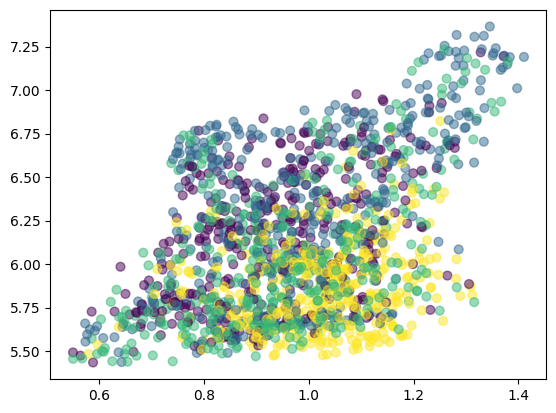

In [153]:
plt.scatter(freqs_umap[:, 0], freqs_umap[:, 10], c = data['era'], alpha = 0.5, s = 40)
plt.show()

In [101]:
from sklearn.manifold import TSNE

In [143]:
freqs_tsne = TSNE(n_components = 3, perplexity = 10, n_jobs = -1).fit_transform(np.array(freqs_data))

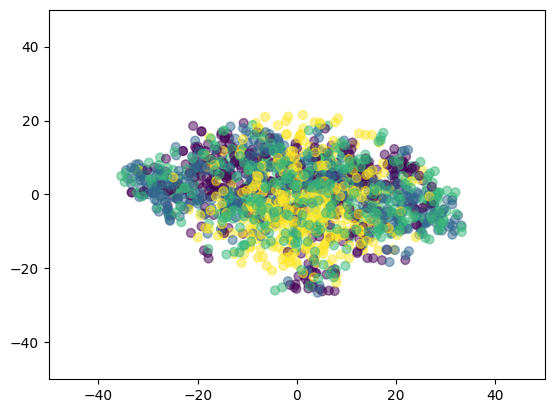

In [163]:
plt.scatter(freqs_tsne[:, 2], freqs_tsne[:, 1], c = data['era'], alpha = 0.5, s = 40)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.show()

In [612]:
from sklearn.decomposition import PCA

In [622]:
pca = PCA(n_components = 10)
freqs_pca = pca.fit_transform(X = np.array(freqs_data))

pca_10 = {}

for i in range(len(keep_pieces)) :
    pca_10[keep_pieces[i]] = freqs_pca[i, :]

In [626]:
# title : era, instrumentation, key, mode, histogram, first_chord, last_chord, transition probabilities, length, time_intervals_mean, time_intervals_std
features = {}
composer_list = []

for piece in keep_pieces :

    # start the new list for the piece title
    features[piece] = []
    
    # get the features
    piece_features = pieces_data[piece]

    # get the composer information 
    composer_list.append(piece_features[5:])

    # era, instrumentation, key, mode
    class_map = {"baroque" : 1, "classical" : 2, "romantic" : 3, "modern" : 4}
    
    era = class_map[piece_features[0].split("_")[1]]
    instrumentation = piece_features[2]
    key = piece_features[3]
    mode = int(piece_features[4] == "major")

    # histogram
    chord_data = chords_data[piece]
    chords = [chord[1] for chord in chords_data[piece]]
    chord_sequence = chord_processing(chords, key)

    if chord_sequence[-1] == -1 :
        key = chord_sequence[-2]
        chord_sequence = chord_sequence[:-2]

    chord_freqs = chord_frequencies(chord_sequence)

    # first and last chord
    first_chord = chord_sequence[0]
    last_chord = chord_sequence[-1]

    # transition probabilities
    pca_transitions = pca_10[piece]

    # time data
    times = [time[0] for time in chord_data][:len(chord_sequence)]
    
    time_diffs = [float(times[i + 1]) - float(times[i]) for i in range(len(times) - 1)]
    time_diffs = np.array(time_diffs)

    # length
    length = float(times[-1])

    # time intervals mean
    interval_mean = np.mean(time_diffs)

    # time intervals std
    interval_std = np.std(time_diffs)
    
    features[piece] += [era, instrumentation, key, mode] + chord_freqs + [first_chord, last_chord] + pca_transitions.tolist() + [length, interval_mean, interval_std]

pca_features = ["pca_" + str(i + 1) for i in range(10)]

column_names = ["era", "instrumentation", "key", "mode", "I", "II", "III", "IV", "T", "V", "VI", "VII", "first_chord", "last_chord"] + pca_features + ["length", "interval_mean", "interval_std"]

pca_data = pd.DataFrame([features[piece] for piece in keep_pieces], columns = column_names)

X = pca_data[list(pca_data.columns)[1:]]
y = pca_data['era']

score = 0

iterations = 1000

for _ in range(iterations) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'first_chord', 'last_chord'],
                                                    learning_rate = 0.25, 
                                                    max_leaf_nodes = 20,
                                                    tol = 1e-5,)
    
    hgb_classifier.fit(X_train, y_train)
    score += hgb_classifier.score(X_test, y_test)
    
print(score / iterations)

0.7153166144200628


In [165]:
# title : era, instrumentation, key, mode, histogram, first_chord, last_chord, transition probabilities, length, time_intervals_mean, time_intervals_std
features = {}
composer_list = []

for piece in keep_pieces :

    # start the new list for the piece title
    features[piece] = []
    
    # get the features
    piece_features = pieces_data[piece]

    # get the composer information 
    composer_list.append(piece_features[5:])

    # era, instrumentation, key, mode
    class_map = {"baroque" : 1, "classical" : 2, "romantic" : 3, "modern" : 4}
    
    era = class_map[piece_features[0].split("_")[1]]
    instrumentation = piece_features[2]
    key = piece_features[3]
    mode = int(piece_features[4] == "major")

    # histogram
    chord_data = chords_data[piece]
    chords = [chord[1] for chord in chords_data[piece]]
    chord_sequence = chord_processing(chords, key)

    if chord_sequence[-1] == -1 :
        key = chord_sequence[-2]
        chord_sequence = chord_sequence[:-2]

    chord_freqs = chord_frequencies(chord_sequence)

    # first and last chord
    first_chord = chord_sequence[0]
    last_chord = chord_sequence[-1]

    # transition probabilities
    umapped_transitions = umap_64[piece]

    # time data
    times = [time[0] for time in chord_data][:len(chord_sequence)]
    
    time_diffs = [float(times[i + 1]) - float(times[i]) for i in range(len(times) - 1)]
    time_diffs = np.array(time_diffs)

    # length
    length = float(times[-1])

    # time intervals mean
    interval_mean = np.mean(time_diffs)

    # time intervals std
    interval_std = np.std(time_diffs)
    
    features[piece] += [era, instrumentation, key, mode] + chord_freqs + [first_chord, last_chord] + umapped_transitions.tolist() + [length, interval_mean, interval_std]
    

In [167]:
umap_features = ["umap" + str(i + 1) for i in range(64)]

column_names = ["era", "instrumentation", "key", "mode", "I", "II", "III", "IV", "T", "V", "VI", "VII", "first_chord", "last_chord"] + umap_features + ["length", "interval_mean", "interval_std"]

In [169]:
umap_data = pd.DataFrame([features[piece] for piece in keep_pieces], columns = column_names)

X = umap_data[list(umap_data.columns)[1:]]
y = umap_data['era']

In [171]:
score = 0

iterations = 1000

for _ in range(iterations) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'first_chord', 'last_chord'],
                                                    learning_rate = 0.25, 
                                                    max_leaf_nodes = 20,
                                                    tol = 1e-5,)
    
    hgb_classifier.fit(X_train, y_train)
    score += hgb_classifier.score(X_test, y_test)
    
print(score / iterations)

0.7029717868338559


## Visualization of Classifications

We use the best model, the one including the first-layer transitions.

We define the following dictionary of composers and their associated colors:

`composer_colors` = {" major" : "white", "Lully; Jean-Baptiste" : "orangered", "Purcell; Henry" : "coral", "Corelli; Arcangelo" : "salmon", "Couperin; Francois" : "lightcoral", "Giustini; Lodovico" : "indianred", "Vivaldi; Antonio" : "firebrick", "Handel; George Frederic" : "brown", "Bach; Johann Sebastian" : "maroon", "Rameau; Jean-Phillipe" : "darkred", "Albinoni; Tomaso" : "brown", "Platti; Giovanni Benedetto" : "firebrick", "Bach; Johann Christian" : "crimson", "Boccherini; Luigi Rodolofo" : "deeppink", "Haydn; Joseph" : "palevioletred", "Salieri; Antonio" : "hotpink", "Mozart; Wolfgang Amadeus" : "orchid", "Haydn; Johann Michael" : "mediumvioletred", "Cimarosa; Domenico" : "m", "Dussek; Jan Ladislav" : "darkmagenta", "Pleyel; Ignace Joseph" : "purple", "Clementi; Muzio" : "darkviolet", "Chopin; Frederic" : "blueviolet", "Mendelssohn-Bartholdy; Felix" : "mediumslateblue", "Berlioz; Hector" : "slateblue", "Schumann; Robert" : "royalblue", "Liszt; Franz" : "cornflowerblue", "Schumann; Clara" : "dodgerblue", "Verdi; Giuseppe" : "lightskyblue", "Wagner; Richard" : "skyblue", "Smetana; Bedrich" : "lightblue", "Borodin; Alexander" : "paleturquoise", "Bruckner; Anton" : "mediumturquoise", "Rimsky-Korsakov; Nicolai" : "turquoise", "Saint-Saens; Camille" : "lightseagreen", "Tchaikovsky; Peter Iljitsch" : "mediumaquamarine", "Brahms; Johannes" : "c", "Dvorak; Antonin" : "darkturquoise", "Dvorak; Antonin" : "cyan", "Grieg; Edvard" : "aqua", "Faure; Gabriel" : "aquamarine", "Mussorgsky; Modest" : "mediumspringgreen", "Berg; Alban" : "springgreen", "Bartok; Bela" : "mediumseagreen", "Webern; Anton" : "seagreen", "Ives; Charles Edward" : "g", "Schoenberg; Arnold" : "darkgreen", "Varese; Edgar" : "green", "Prokofiew; Sergej" : "forestgreen", "Weill; Kurt" : "limegreen", "Hindemith; Paul" : "lime", "Stravinsky; Igor" : "lawngreen", "Milhaud; Darius" : "lightgreen", "Shostakovich; Dmitri" : "palegreen", "Messiaen; Olivier" : "greenyellow", "Antheil; George" : "chartreuse", "Britten; Benjamin" : "greenyellow", "Boulez; Pierre" : "lawngreen"}

In [595]:
# unique_composers = set([composer[0] for composer in composer_list])

composer_colors = {" major" : "white", "Lully; Jean-Baptiste" : "orangered", "Purcell; Henry" : "coral", "Corelli; Arcangelo" : "salmon", "Couperin; Francois" : "lightcoral", "Giustini; Lodovico" : "indianred", "Vivaldi; Antonio" : "firebrick", "Handel; George Frederic" : "brown", "Bach; Johann Sebastian" : "maroon", "Rameau; Jean-Phillipe" : "darkred", "Albinoni; Tomaso" : "brown", "Platti; Giovanni Benedetto" : "firebrick", "Bach; Johann Christian" : "crimson", "Boccherini; Luigi Rodolofo" : "deeppink", "Haydn; Joseph" : "palevioletred", "Salieri; Antonio" : "hotpink", "Mozart; Wolfgang Amadeus" : "orchid", "Haydn; Johann Michael" : "mediumvioletred", "Cimarosa; Domenico" : "m", "Dussek; Jan Ladislav" : "darkmagenta", "Pleyel; Ignace Joseph" : "purple", "Clementi; Muzio" : "darkviolet", "Chopin; Frederic" : "blueviolet", "Mendelssohn-Bartholdy; Felix" : "mediumslateblue", "Berlioz; Hector" : "slateblue", "Schumann; Robert" : "royalblue", "Liszt; Franz" : "cornflowerblue", "Schumann; Clara" : "dodgerblue", "Verdi; Giuseppe" : "lightskyblue", "Wagner; Richard" : "skyblue", "Smetana; Bedrich" : "lightblue", "Borodin; Alexander" : "paleturquoise", "Bruckner; Anton" : "mediumturquoise", "Rimsky-Korsakov; Nicolai" : "turquoise", "Saint-Saens; Camille" : "lightseagreen", "Tchaikovsky; Peter Iljitsch" : "mediumaquamarine", "Brahms; Johannes" : "c", "Dvorak; Antonin" : "darkturquoise", "Dvorak; Antonin" : "cyan", "Grieg; Edvard" : "aqua", "Faure; Gabriel" : "aquamarine", "Mussorgsky; Modest" : "mediumspringgreen", "Berg; Alban" : "springgreen", "Bartok; Bela" : "mediumseagreen", "Webern; Anton" : "seagreen", "Ives; Charles Edward" : "g", "Schoenberg; Arnold" : "darkgreen", "Varese; Edgar" : "green", "Prokofiew; Sergej" : "forestgreen", "Weill; Kurt" : "limegreen", "Hindemith; Paul" : "lime", "Stravinsky; Igor" : "lawngreen", "Milhaud; Darius" : "lightgreen", "Shostakovich; Dmitri" : "palegreen", "Messiaen; Olivier" : "greenyellow", "Antheil; George" : "chartreuse", "Britten; Benjamin" : "greenyellow", "Boulez; Pierre" : "lawngreen"}
colors = [composer_colors[composer[0]] for composer in composer_list]

composer_years = []

for composer in composer_list :
    try :
        year1 = float(composer[1].split("-")[0])
        try :
            year2 = float(composer[1].split("-")[1])
        except ValueError :
            year2 = year1
            
        year = 1/2 * (year1 + year2)
        composer_years.append(year)
    except ValueError :
        year = float(composer[2].split("-")[0])
        composer_years.append(year)

composer_years = [year + np.random.uniform(0, 0.01, 1) for year in composer_years]

piece_eras = (data['era'] + np.random.normal(0, 0.12, len(data['era'])))

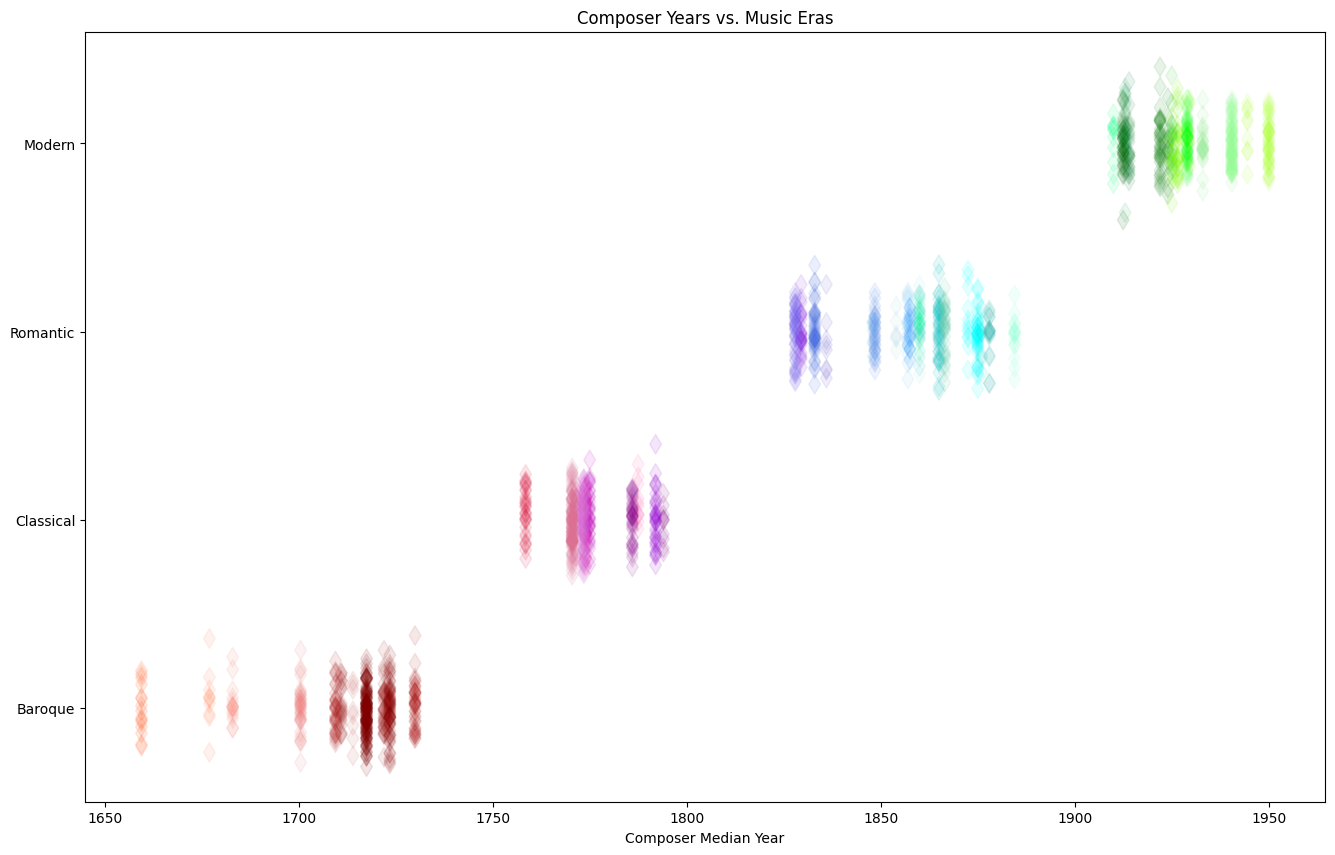

In [597]:
fig, ax = plt.subplots(figsize = (16, 10))
ax.scatter(composer_years, piece_eras, color = colors, alpha = 0.10, s = 100, marker = "d")
ax.set_yticks([1, 2, 3, 4])
ax.set_title('Categories on Years')
ax.set_yticklabels(["Baroque", "Classical", "Romantic", "Modern"])
ax.set_title('Composer Years vs. Music Eras')
ax.set_xlabel("Composer Median Year")
plt.show()

In [345]:
X = data[list(data.columns)[1:]]
y = data['era']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
hgb_1layer = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'first_chord', 'last_chord'],
                                                    learning_rate = 0.1, 
                                                    max_leaf_nodes = 20,
                                                    tol = 1e-5,)
    
hgb_1layer.fit(X_train, y_train)
predicted = hgb_1layer.predict(X)
print((hgb_1layer.score(X_train, y_train), hgb_1layer.score(X_test, y_test)))

(1.0, 0.774294670846395)


In [529]:
new_colors = []

for i in range(len(y)) :
    if predicted[i] != y[i] :
        new_colors.append("black")
    else :
        new_colors.append(colors[i])

In [601]:
piece_eras = 2 * (data['era'] + np.random.normal(0, .25, len(data['era'])))

colors_data = pd.concat([pd.Series(composer_years), pd.Series(piece_eras), pd.Series(new_colors)], axis = 1)
colors_correct = colors_data[colors_data[1] != "black"]
colors_incorrect = colors_data[colors_data[1] == "black"]

# colors_data = pd.concat([colors_correct, colors_incorrect])

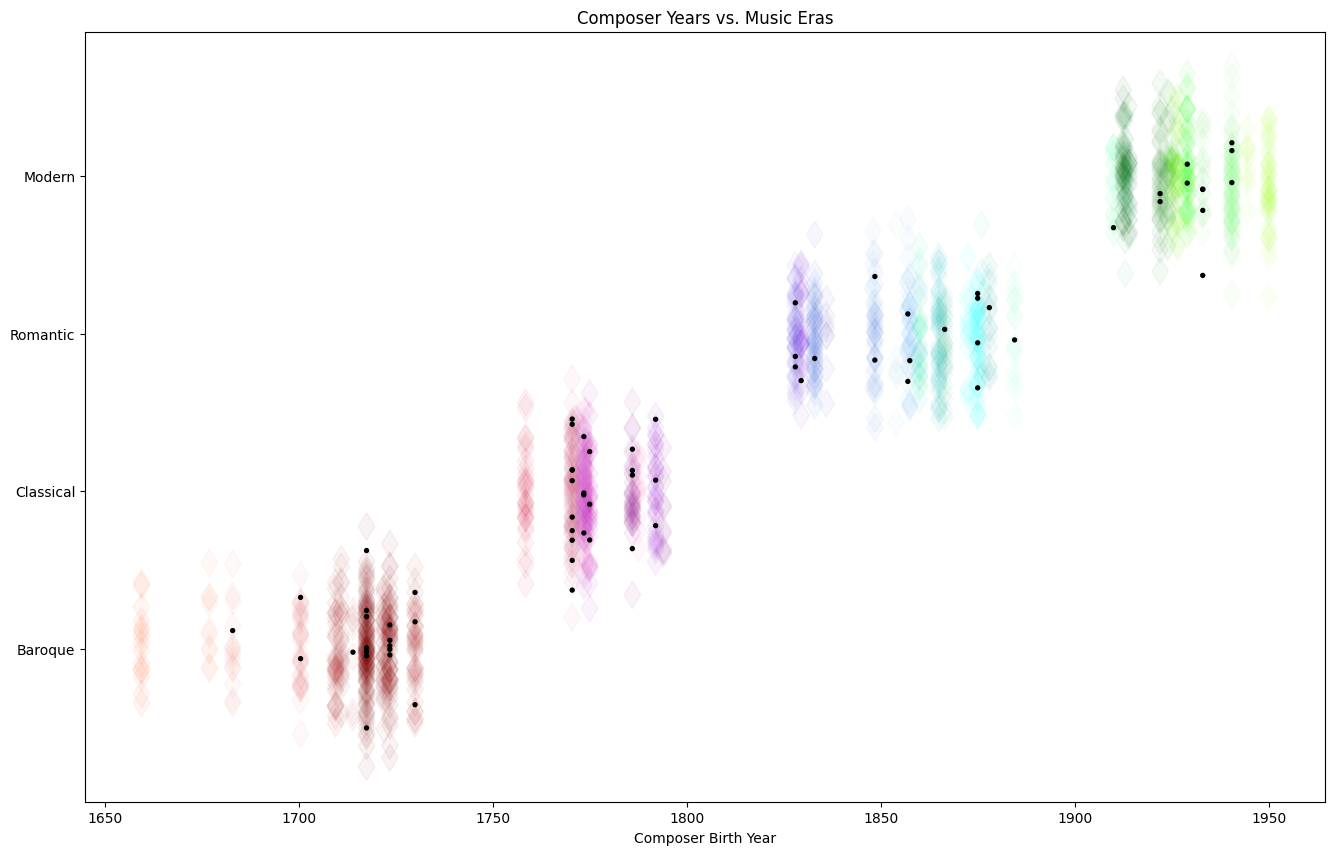

In [603]:
fig, ax = plt.subplots(figsize = (16, 10))
ax.scatter(colors_correct[0], colors_correct['era'], color = colors_correct[1], alpha = 0.05, s = 200, marker = "d")
ax.scatter(colors_incorrect[0], colors_incorrect['era'], color = colors_incorrect[1], alpha = 1.0, s = 8, marker = "o")
ax.set_yticks([2, 4, 6, 8])
ax.set_yticklabels(["Baroque", "Classical", "Romantic", "Modern"])
ax.set_title('Composer Years vs. Music Eras')
ax.set_xlabel("Composer Birth Year")
plt.show()

In [315]:
X = data[list(data.columns)[1:]]
y = data['era']

iterations = 1

train_score = 0
test_score = 0

for _ in range(iterations):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    hgb_1layer = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'first_chord', 'last_chord'],
                                                    learning_rate = 0.1, 
                                                    max_leaf_nodes = 20,
                                                    tol = 1e-5,)
    
    hgb_1layer.fit(X_train, y_train)
    train_score += hgb_1layer.score(X_train, y_train)
    test_score += hgb_1layer.score(X_test, y_test)

print((train_score / iterations, test_score / iterations))

(1.0, 0.7398119122257053)


## Miscellaneous Models

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

X = data[list(data.columns)[1:]]
y = data['era']

X_et = pd.get_dummies(X)

train_score = 0
test_score = 0

iterations = 100

for _ in range(iterations) :
    
    X_train, X_test, y_train, y_test = train_test_split(X_et, y, test_size = 0.2)
    
    et = ExtraTreesClassifier(n_estimators = 100)
    et.fit(X_train, y_train)
    
    train_score += et.score(X_train, y_train)
    test_score += et.score(X_test, y_test)

print(train_score / iterations, test_score / iterations)

In [ ]:
!pip install xgboost

In [269]:
from xgboost import XGBClassifier

X = data[list(data.columns)[1:]]
y = data['era']

train_score = 0
test_score = 0

iterations = 100

X_xgb = pd.get_dummies(X)
y_xgb = [ele - 1 for ele in y]

for _ in range(iterations) :
    X_train, X_test, y_train, y_test = train_test_split(X_xgb, y_xgb, test_size = 0.2)
    
    xgb = XGBClassifier(enable_categories = True, max_depth = 20, max_leaves = 12)
    xgb.fit(X_train, y_train)
    
    train_score += xgb.score(X_train, y_train)
    test_score += xgb.score(X_test, y_test)

print(train_score / iterations, test_score / iterations)

1.0 0.7326959247648902


In [261]:
X

,instrumentation,key,mode,I,II,III,IV,T,V,VI,...,VII-II,VII-III,VII-IV,VII-T,VII-V,VII-VI,VII-VII,length,interval_mean,interval_std
0,orchestra,G,0,8,5,7,6,0,10,4,...,0.000000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,67.5,1.597619,1.070934
1,orchestra,G,0,19,2,11,14,0,11,3,...,0.000000,0.307692,0.153846,0.000000,0.000000,0.076923,0.000000,132.5,1.834722,1.386258
2,orchestra,G,0,8,2,4,9,0,6,3,...,0.000000,0.250000,0.125000,0.000000,0.000000,0.125000,0.000000,62.5,1.592308,0.807460
3,orchestra,G,0,15,1,8,10,0,14,8,...,0.000000,0.750000,0.125000,0.000000,0.000000,0.000000,0.000000,103.8,1.641270,1.521031
4,orchestra,A,0,22,18,21,27,2,11,10,...,0.125000,0.208333,0.250000,0.000000,0.083333,0.125000,0.041667,307.4,2.291791,1.583358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,piano,C#,0,31,11,13,13,0,17,14,...,0.000000,0.083333,0.000000,0.000000,0.166667,0.250000,0.000000,210.9,1.910000,1.037387
1588,piano,Bb,1,14,13,4,1,3,10,17,...,0.000000,0.000000,0.000000,0.100000,0.000000,0.300000,0.000000,193.2,2.715493,3.870315
1589,piano,F,1,58,33,41,40,11,52,52,...,0.041667,0.250000,0.083333,0.083333,0.083333,0.208333,0.000000,711.6,2.292903,2.296677
1590,piano,Ab,0,24,6,10,2,1,5,3,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,174.4,3.403922,3.486667


In [239]:
chord_sequences = {}

chord_numerical_mapping = {"I":1, "II":2, "III":3, "IV":4, "T":4.5, "V":5, "VI":6, "VII":7}

for piece in keep_pieces :
    chord_data = chords_data[piece]
    chords = [chord[1] for chord in chords_data[piece]]
    chord_sequence = chord_processing(chords, key)

    if chord_sequence[-1] == -1 :
        key = chord_sequence[-2]
        chord_sequence = chord_sequence[:-2]

    chord_sequence = [chord_numerical_mapping[chord] for chord in chord_sequence]

    chord_sequences[piece] = chord_sequence

In [697]:
data['key'].value_counts()

key
              239
D             203
C             191
G             178
A             136
F             117
Bb            105
Eb            101
E              98
B              67
Ab             38
Db             32
F#             30
C#             22
Gb             15
G#              8
D#              4
A#              4
various         2
modulation      1
Bb              1
Name: count, dtype: int64